## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [168]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.corpus import stopwords
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("./data/complaints-2021-05-14_08_16.json",encoding='utf-8')

# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)
df.head(8)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A


## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
df.astype("category").describe()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
count,78313,78313,78313,78313.0,10900,71556,78313,78313,78313,76322,...,78313,78313,78313,78313,4,67742,78313,78313,32016,77305
unique,1,1,78313,1.0,3,9442,78313,154,3444,62,...,8,1,6,3309,3,72,2,20931,205,5
top,complaint-public-v2,complaint,1000007,0.0,Older American,606XX,1000007,"Loan modification,collection,foreclosure",2015-08-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2012-06-21T12:00:00-05:00,Company has responded to the consumer and the ...,Checking account,Yes,,Credit card company isn't resolving a dispute ...,N/A
freq,78313,78313,1,78313.0,6103,472,1,9743,82,14009,...,60230,78313,47972,105,2,17182,78217,57241,2904,42847


In [5]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign new column names
new_cols = []
for col in df.columns:
    new_cols.append(re.sub('^_','',re.sub('_source.',"",col), count=1))

df.columns = new_cols

print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [7]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#Assign nan in place of blanks in the complaints column
df.loc[df["complaint_what_happened"] == "","complaint_what_happened"] = np.nan

In [9]:
#Remove all rows where complaints column is nan
print(df.shape)
df.dropna(subset=["complaint_what_happened"], inplace=True)
print(df.shape)

(78313, 22)
(21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_complaints_text(complaint):
    text = complaint.lower()
    text = re.sub('[\d]+', "", re.sub('[^\w\s]', "",re.sub('\([\w\W\s]*\)',"",text)))
    return text

df["complaint_what_happened"] = df["complaint_what_happened"].apply(preprocess_complaints_text)

In [11]:
#Write your function to Lemmatize the texts
def lemma_of_text(complaint):
    doc = nlp(complaint)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text


df["lemmatized_complaints"] = tqdm([lemma_of_text(complnt) for complnt in df["complaint_what_happened"].values])

100%|████████████████████████████████████████████████████████████████████████| 21072/21072 [00:00<00:00, 113364.37it/s]


In [112]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["lemmatized_complaints","complaint_what_happened"]].copy(deep=True)

In [113]:
df_clean.columns = ["lemmatized_complaints","complaints"]
df_clean.head()

,lemmatized_complaints,complaints
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...
2,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...
10,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...
11,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...


In [115]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    pos_tags = " ".join([token.text for token in doc if token.tag_ == "NN"])
    return pos_tags


df_clean["complaint_POS_removed"] = tqdm([ pos_tag(lemma_complnt) for lemma_complnt in df_clean["lemmatized_complaints"].values]) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|████████████████████████████████████████████████████████████████████████| 21072/21072 [00:00<00:00, 138234.61it/s]


In [116]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,lemmatized_complaints,complaints,complaint_POS_removed
1,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...
2,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...
10,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...,chase card report application identity consent...
11,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after be a chase card customer for well over a...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx I call chas my xxxx xxxx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...
78310,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,xxxx risk consumer chase bank app chase year b...
78311,I have have flawless credit for yrs I ve hav...,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [117]:
# Write your code here to visualise the data according to the 'Complaint' character length
px.scatter(df_clean,y=[len(complaint) for complaint in df_clean["complaints"]],labels={'y': 'Complaint Length', 'index': 'Complaint Index'},)
# help(px.scatter)

In [118]:
# Create a histogram using Plotly Express
fig = px.histogram(x=df_clean["complaints"].apply(len), nbins=100, 
                   labels={'x': 'Frequency','count': 'Complaint Length'},
                   title='Distribution of Complaint Lengths')

# Show the plot
fig.show()

In [119]:
# !pip install wordcloud

#### Find the top 40 words by frequency among all the articles after processing the text.

In [120]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from nltk.tokenize import word_tokenize
all_complaint_words = [word.lower() for complaints in df_clean["lemmatized_complaints"] for word in word_tokenize(complaints) if word.isalpha() and word.lower() not in stopwords.words("english")]

In [121]:
from collections import Counter

# Calculate word frequencies
word_frequency = Counter(all_complaint_words)

# Select top 40 words by frequency
top_words_frequency = word_frequency.most_common(40)
print(top_words_frequency)

# Create a word cloud
word_labels = [word[0] for word in top_words_frequency]
frequency_labels = [word[1] for word in top_words_frequency]

px.bar(x=word_labels, y=frequency_labels,title="Top 40 most common words by frequency",labels={'x': 'Common Words', 'y': "Word Frequency"})

[('xxxx', 152569), ('chase', 65623), ('account', 40365), ('credit', 28752), ('card', 25492), ('bank', 24150), ('xxxxxxxx', 21847), ('call', 20632), ('payment', 17305), ('would', 16574), ('tell', 15767), ('charge', 14851), ('make', 14117), ('receive', 14010), ('pay', 13902), ('time', 12879), ('check', 12571), ('say', 12461), ('get', 12454), ('go', 10563), ('report', 10460), ('day', 10394), ('send', 10344), ('money', 10282), ('back', 9235), ('loan', 8776), ('ask', 8666), ('close', 8487), ('never', 8307), ('take', 7959), ('could', 7936), ('use', 7644), ('contact', 7581), ('state', 7431), ('fee', 7421), ('information', 7406), ('letter', 7377), ('claim', 7273), ('month', 7076), ('give', 7060)]


In [122]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [123]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_ngram(text,n=1):
    tokens = word_tokenize(text)
    unigrams = zip(*[tokens[i:] for i in range(0,n)])
    unigrams = [" ".join(gram) for gram in unigrams]
    return unigrams

all_unigram = [grams for doc in df_clean["Complaint_clean"].values for grams in get_ngram(doc)]
top_thirty_unigram = Counter(all_unigram).most_common(30)

#Plot Uniigram frequency distribution
unigram_word_labels = [word[0] for word in top_thirty_unigram]
unigram_frequency_labels = [word[1] for word in top_thirty_unigram]

px.bar(x=unigram_word_labels, y=unigram_frequency_labels,title="Top 30 unigrams by frequency",labels={'x': 'Unigram', 'y': "Unigram Frequency"})

In [124]:
#Print the top 10 words in the unigram frequency
unigram_df = pd.DataFrame({'unigrams': unigram_word_labels, 'frequency': unigram_frequency_labels})
unigram_df.head(10)

,unigrams,frequency
0,chase,42697
1,account,38830
2,xxxx,38460
3,credit,28193
4,card,25207
5,bank,18116
6,payment,17300
7,time,12871
8,charge,11357
9,xxxxxxxx,10550


In [125]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
all_bigram = [grams for doc in df_clean["Complaint_clean"].values for grams in get_ngram(doc,2)]
top_thirty_bigram = Counter(all_bigram).most_common(30)

#Plot Bigram frequency distribution
bigram_word_labels = [word[0] for word in top_thirty_bigram]
bigram_frequency_labels = [word[1] for word in top_thirty_bigram]

px.bar(x=bigram_word_labels, y=bigram_frequency_labels,title="Top 30 bigrams by frequency",labels={'x': 'Bigram', 'y': "Bigram Frequency"})

In [126]:
#Print the top 10 words in the bigram frequency
bigram_df = pd.DataFrame({'bigrams': bigram_word_labels, 'frequency': bigram_frequency_labels})
bigram_df.head(10)

,bigrams,frequency
0,credit card,10850
1,xxxx xxxx,3783
2,credit report,3506
3,customer service,2506
4,chase credit,2353
5,account chase,2309
6,chase account,2094
7,bank account,2028
8,check account,1897
9,account account,1746


In [127]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
all_trigram = [grams for doc in df_clean["Complaint_clean"].values for grams in get_ngram(doc,3)]
top_thirty_trigram = Counter(all_trigram).most_common(30)

#Plot Bigram frequency distribution
trigram_word_labels = [word[0] for word in top_thirty_trigram]
trigram_frequency_labels = [word[1] for word in top_thirty_trigram]

px.bar(x=trigram_word_labels, y=trigram_frequency_labels,title="Top 30 trigrams by frequency",labels={'x': 'Trigram', 'y': "Trigram Frequency"})

In [128]:
#Print the top 10 words in the trigram frequency
trigram_df = pd.DataFrame({'trigrams': trigram_word_labels, 'frequency': trigram_frequency_labels})
trigram_df.head(10)

,trigrams,frequency
0,chase credit card,1582
1,credit card account,921
2,credit card company,856
3,xxxx credit card,679
4,credit card chase,595
5,xxxx xxxx xxxx,541
6,inquiry credit report,457
7,credit card credit,431
8,credit card xxxx,336
9,account credit card,331


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [129]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [130]:
#All masked texts has been removed
df_clean.reset_index(inplace=True, drop=True)
df_clean

,lemmatized_complaints,complaints,complaint_POS_removed,Complaint_clean
0,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...
1,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...
2,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...,chase card report application identity consent...,chase card report application identity consent...
3,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
4,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
21067,after be a chase card customer for well over a...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx I call chas my xxxx xxxx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
21069,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
21070,I have have flawless credit for yrs I ve hav...,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [131]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [132]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = vectorizer.fit_transform(df_clean['Complaint_clean'].values)
pd.DataFrame(document_term_matrix.toarray(), columns=vectorizer.get_feature_names_out())

,aarp,abandonment,abatement,abet,abide,ability,abovementione,abovereference,absence,absolve,...,yield,youinv,youth,yr,yrs,ytd,zap,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.25998,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [133]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [134]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here

In [135]:
nmf_model.fit(document_term_matrix)
topic_term_matrix = nmf_model.components_
len(vectorizer.get_feature_names_out())

5974

In [136]:
topic_term_matrix.shape

(5, 5974)

In [137]:
#Print the Top15 words for each of the topics
words = vectorizer.get_feature_names_out()
topic_words = pd.DataFrame(np.zeros((num_topics,15)),
             index=[f"Topic {i +1}" for i in range(num_topics)],
             columns=[f"Word {i +1}" for i in range(15)]
            )

for i in range(num_topics):
    ix = topic_term_matrix[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,chase,fund,deposit,branch,day,checking,business,number,transfer,transaction,customer
Topic 2,card,credit,chase,balance,account,limit,score,year,point,purchase,month,offer,application,service,time
Topic 3,payment,loan,mortgage,chase,home,month,modification,time,year,rate,property,balance,statement,date,day
Topic 4,report,inquiry,credit,company,information,reporting,identity,debt,account,score,theft,letter,file,date,dispute
Topic 5,charge,fee,transaction,dispute,chase,merchant,claim,fraud,purchase,service,time,refund,company,day,email


#### Analysis of the topic

- Topic 1: Banking services/Banking operations
- Topic 2: Credit Card services
- Topic 3: Loans and Mortgages
- Topic 4: Complaints/Disputes/Thefts or Inqueries
- Topic 5: Other Services

In [138]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
document_topics = nmf_model.transform(document_term_matrix)

In [139]:
#Assign the best topic to each of the complaints in Topic Column
df_clean['Topic'] = document_topics.argmax(axis=1) #write your code to assign topics to each rows.

In [140]:
df_clean.head()

,lemmatized_complaints,complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
1,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
2,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,3
3,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
4,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [141]:
#Print the first 5 Complaint for each of the Topics
df_clean_grouped=df_clean.groupby('Topic').head(5)
df_clean_grouped.sort_values('Topic')

,lemmatized_complaints,complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
10,mishandle of this account by chase auto and xxxx,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,mishandle account chase auto,0
6,with out notice jp morgan chase restrict my ac...,with out notice jp morgan chase restricted my ...,notice account debit card xxxx branch customer...,notice account debit card branch customer ser...,0
4,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
12,I open an account with chase bank on xxxx and ...,i opened an account with chase bank on xxxx an...,account bank code bonus xxxxxxxx term everythi...,account bank code bonus term everything accou...,0
14,my chase amazon card be decline for a catering...,my chase amazon card was declined for a cateri...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,1
25,I currently have over xxxx chase ultimate rewa...,i currently have over xxxx chase ultimate rewa...,chase reward point xxxx week customer support ...,chase reward point week customer support tick...,1
22,my roommate be steal my chase debit card and d...,my roommate was stealing my chase debit card a...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,1
1,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
21,I be a senior citizen that have be scamme by s...,i am a senior citizen that has been scammed by...,citizen company time share company nothing ref...,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [142]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 4:"Others", 3:"Theft/Dispute reporting", 2:"Mortgages/loans" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [143]:
df_clean

,lemmatized_complaints,complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,Bank account services
1,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,Credit card / Prepaid card
2,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,Theft/Dispute reporting
3,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Theft/Dispute reporting
4,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Bank account services
...,...,...,...,...,...
21067,after be a chase card customer for well over a...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card / Prepaid card
21068,on wednesday xxxxxxxx I call chas my xxxx xxxx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Others
21069,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,Theft/Dispute reporting
21070,I have have flawless credit for yrs I ve hav...,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [144]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":4, "Theft/Dispute reporting":3, "Mortgages/loans":2 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [145]:
df_clean

,lemmatized_complaints,complaints,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name be xxxx xxxx and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank service ask debt verifi...,morning name stop bank service ask debt verifi...,0
1,I upgrade my xxxx xxxx card in xxxx and be tel...,i upgraded my xxxx xxxx card in xxxx and was t...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information...,1
2,chase card be report on xxxx however fraudulen...,chase card was reported on xxxx however fraudu...,chase card report application identity consent...,chase card report application identity consent...,3
3,on xxxx while try to book a xxxx xxxx tick...,on xxxx while trying to book a xxxx xxxx tic...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,3
4,my grand son give I check for I deposit it i...,my grand son give me check for i deposit it i...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
21067,after be a chase card customer for well over a...,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
21068,on wednesday xxxxxxxx I call chas my xxxx xxxx...,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,4
21069,I be not familiar with xxxx pay and do not und...,i am not familiar with xxxx pay and did not un...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,3
21070,I have have flawless credit for yrs I ve hav...,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,1


In [146]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints', 'Topic']].copy(deep=True)

In [147]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   complaints  21072 non-null  object
 1   Topic       21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [148]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
train_count = count_vect.fit_transform(training_data["complaints"].values)

#Write your code here to transform the word vector to tf-idf
tfidf_transform = TfidfTransformer()
train_tfidf = tfidf_transform.fit_transform(train_count)

(21072,)
(21072, 29591)


In [149]:
train_tfidf.shape

(21072, 29591)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

### Logistic Regression

In [172]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Importing LogisticRegression from sklearn and Train-Test Split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(train_tfidf, training_data['Topic'], test_size=0.20, random_state=40)

In [173]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 29591)
(4215, 29591)
(16857,)
(4215,)


In [152]:
logreg_model = LogisticRegression(random_state=40, solver='liblinear')
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=40, solver='liblinear')

In [153]:
logreg_model.score(X_test, y_test)

0.9036773428232503

##### The Logistic Regressions base model gives a `90.37%` accuracy

In [154]:
confusion_matrix(y_test, logreg_model.predict(X_test))

array([[971,  13,  11,   6,  28],
       [ 19, 744,  16,  12,  44],
       [ 19,  12, 982,   8,  18],
       [ 13,  22,  33, 372,   9],
       [ 68,  14,  30,  11, 740]], dtype=int64)

In [159]:
logreg_gridcv_params = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [160]:
logreg_gridcv = GridSearchCV(LogisticRegression(random_state=40),
                                param_grid=logreg_gridcv_params,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_gridcv.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [161]:
logreg_gridcv.best_params_

{'C': 3, 'solver': 'liblinear'}

In [162]:
# Get the scores of the best logistic regression model
logreg_gridcv.score(X_test, y_test)

0.9141162514827995

##### The tuned logistic regression model gives an accuracy of `91.4%`, which an improvement over the accuracy of the base models `90.37%`.

In [163]:
y_pred = logreg_gridcv.predict(X_test)

In [164]:
confusion_matrix(y_test, y_pred)

array([[972,  13,   6,   5,  33],
       [ 14, 767,  12,  10,  32],
       [ 19,  12, 978,  10,  20],
       [ 13,  16,  25, 386,   9],
       [ 59,  15,  27,  12, 750]], dtype=int64)

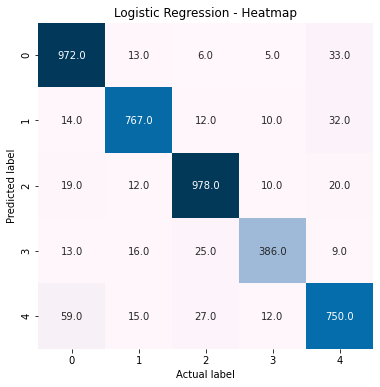

In [169]:
# Visualize Confusion Matrix with heatmap for logistic regression
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="PuBu", fmt = '0.1f')
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
plt.title("Logistic Regression - Heatmap")
plt.show()

In [170]:
topicnames = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]

In [174]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.90      0.94      0.92      1029
Credit card / Prepaid card       0.93      0.92      0.93       835
                    Others       0.93      0.94      0.94      1039
   Theft/Dispute reporting       0.91      0.86      0.89       449
           Mortgages/loans       0.89      0.87      0.88       863

                  accuracy                           0.91      4215
                 macro avg       0.91      0.91      0.91      4215
              weighted avg       0.91      0.91      0.91      4215



##### Observations:
- The overall accuracy of the Logistic Regression model is `91.4%`.
- The Precision and Recall are `91%` and `91%` respectively which makes this is a very good model.

### Decision Tree

In [175]:
# Import decision tree library
from sklearn.tree import DecisionTreeClassifier

In [176]:
# Re-initialize the train-test split variables
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, training_data['Topic'], test_size=0.20, random_state=40)

In [177]:
dt = DecisionTreeClassifier(random_state=40)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=40)

In [178]:
print(dt.score(X_test, y_test))

0.7734282325029656


##### The Decision Tree's base model gives us an accuracy of `77%`

In [179]:
dt_grid_params = {"max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(2, 20, 2)}

In [180]:
# Initialise and fit the grid search cross validation for decision tree
dt_gridcv = GridSearchCV(DecisionTreeClassifier(random_state=40),
                                param_grid=dt_grid_params,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
dt_gridcv.fit(X_train, y_train);

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [181]:
print(dt_gridcv.best_params_)

{'max_depth': 10, 'min_samples_leaf': 18, 'min_samples_split': 2}


In [182]:
print(dt_gridcv.score(X_test, y_test))

0.7556346381969158


##### The fine tuned decision tree classifier model gives an accuracy of `75.56%`, this is a decrease over the accuracy of `77%` of the base model.

In [183]:
y_pred = dt_gridcv.predict(X_test)

In [184]:
print(confusion_matrix(y_test, y_pred))

[[801  48  46  11 123]
 [ 36 672   8  48  71]
 [ 42  47 816  29 105]
 [ 45  34  27 275  68]
 [103  88  37  14 621]]


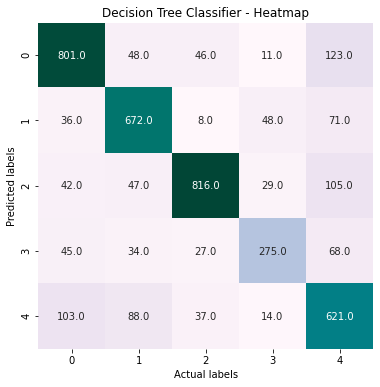

In [185]:
# Visualize Confusion Matrix with heatmap for decision tree
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="PuBuGn", fmt = '0.1f')
plt.xlabel("Actual labels")
plt.ylabel("Predicted labels")
plt.title("Decision Tree Classifier - Heatmap")
plt.show()

In [186]:
print(classification_report(y_test, y_pred, target_names = topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.78      0.78      1029
Credit card / Prepaid card       0.76      0.80      0.78       835
                    Others       0.87      0.79      0.83      1039
   Theft/Dispute reporting       0.73      0.61      0.67       449
           Mortgages/loans       0.63      0.72      0.67       863

                  accuracy                           0.76      4215
                 macro avg       0.75      0.74      0.74      4215
              weighted avg       0.76      0.76      0.76      4215



##### Obervations:
- The decision tree classifier's base model gives an accuracy score of `77%`.
- The fine-tuned decision tree classifier scores an accuracy of `75.56%` 
- The Precision and Recall are `75%` and `74%` which when compared to logistic regression, is `not a very good model`.

### Random Forest Classifier

In [187]:
from sklearn.ensemble import RandomForestClassifier

In [188]:
# Re-initialize the train-test split variables
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, training_data['Topic'], test_size=0.20, random_state=40)

In [189]:
rf = RandomForestClassifier(random_state=40)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=40)

In [190]:
rf.score(X_test, y_test)

0.8180308422301305

##### The base Random Forest Classifier has an accuracy score of `81.8%`

In [191]:
rf_gridcv_params = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [2, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(2, 20, 2)}

In [192]:
rf_gridcv = RandomizedSearchCV(RandomForestClassifier(random_state=40),
                                param_distributions=rf_gridcv_params,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_gridcv.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [193]:
print(rf_gridcv.best_params_)

{'n_estimators': 260, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_depth': 10}


In [194]:
print(rf_gridcv.score(X_test, y_test))

0.7022538552787663


##### The fine tuned Random Forest Classifier model has an accuracy of `70.2%`

In [195]:
y_pred = rf_gridcv.predict(X_test)

In [196]:
print(confusion_matrix(y_test, y_pred))

[[987   4  31   1   6]
 [205 404 127   0  99]
 [ 57   3 973   0   6]
 [114  61 147 116  11]
 [263  20 100   0 480]]


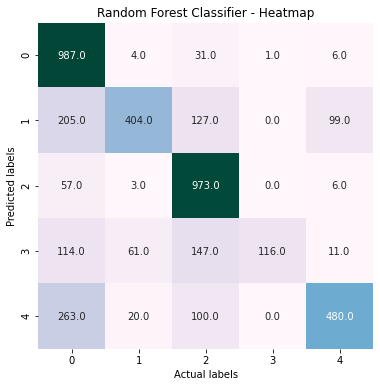

In [197]:
# Visualize Confusion Matrix with heatmap for random forest
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="PuBuGn", fmt = '0.1f')
plt.xlabel("Actual labels")
plt.ylabel("Predicted labels")
plt.title("Random Forest Classifier - Heatmap")
plt.show()

In [198]:
# Print Classification Report
print(classification_report(y_test, y_pred, target_names = topicnames))

                            precision    recall  f1-score   support

     Bank account services       0.61      0.96      0.74      1029
Credit card / Prepaid card       0.82      0.48      0.61       835
                    Others       0.71      0.94      0.81      1039
   Theft/Dispute reporting       0.99      0.26      0.41       449
           Mortgages/loans       0.80      0.56      0.66       863

                  accuracy                           0.70      4215
                 macro avg       0.78      0.64      0.64      4215
              weighted avg       0.75      0.70      0.68      4215



##### Obervations:
- The base random forest base model has an accuracy of `81.8%` 
- The fine-tuned model has an accuracy of `70%` which is a significant decline compared to the base model.
- The Precision and Recall is `78%` and `64%` respectively

### Final Obervations:
- #### Logistic Regression
    - The overall accuracy of the Logistic Regression model is `91%`.
    - The Precision and Recall are `91%` and `91%` respectively which makes this is a very good model.
- #### Decision Tree Classifier
    - The decision tree classifier has an accuracy score of `76%`.
    - The Precision and Recall are `75%` and `74%` which when compared to logistic regression, is `not a very good model`.
- #### Random Forest Classifier
    - The base random forest base model has an accuracy of `70%`
    - The Precision and Recall is `78%` and `64%` respectively, which when compared to logistic regression, is `not a very good model`.

### Conclusion:
- The best model is Logistic Regression with an accuracy score of `91%` 